In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
ls

CreateDataset.ipynb    MobileNetV2+SSD_v1.ipynb  TestKeras.ipynb
data/                  MobileNetV2+SSD_v2.ipynb
MobileNetV2+SSD.ipynb  MobileNetV2+SSD_v3.ipynb


In [29]:
import tensorflow as tf
import numpy as np
from numpy import matlib
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras import backend as K

In [30]:
IMG_SIZE = 224
NUM_CLASSES = 10

layerWidths = [28,14,7,4,2,1]
numBoxes = [3,3,3,3,3,3]
assert len(numBoxes) == len(layerWidths) # numBoxes for each layer and each layer has a specific width
outputChannels = NUM_CLASSES + 1 + 4 # 10 classes + background + cx,cy,h,w
assert outputChannels - NUM_CLASSES == 5

In [31]:
# number of scales is equal to the number of different resolutions ie num of layer widths
# for a given resolution, we have different aspect ratios
MinScale = .1 # Min and Max scale given as percentage
MaxScale = 1.5
scales = [MinScale + x/len(layerWidths) * (MaxScale-MinScale) for x in range(len(layerWidths))]
scales = scales[::-1] # reversing the order because the layerWidths go from high to low (lower to higher resoltuion)

asp = [0.5,1.0,1.5]
asp1 = [x**0.5 for x in asp]
asp2 = [1/x for x in asp1]

In [32]:
# should be equal to the 1st dimension in the output layer of the SSD model
BOXES = sum([a*a*b for a,b in zip(layerWidths,numBoxes)])
centres = np.zeros((BOXES,2))
hw = np.zeros((BOXES,2))
boxes = np.zeros((BOXES,4))
print(BOXES)

3150


In [33]:
# calculating the default box centres and height, width
idx = 0

for gridSize, numBox, scale in zip(layerWidths,numBoxes,scales):
    step_size = IMG_SIZE*1.0/gridSize
    for i in range(gridSize):
        for j in range(gridSize):
            pos = idx + (i*gridSize+j) * numBox
            # centre is the same for all bounding boxes
            centres[pos:pos+numBox, :] = i*step_size + step_size/2, j*step_size + step_size/2
            # height and width vary according to the scale and aspect ratio
            # zip asepct ratios and then scale them by the scaling factor
            hw[pos:pos+numBox, :] = np.multiply(gridSize*scale, np.squeeze(np.dstack([asp1,asp2]),axis=0))[:numBox,:]

    idx += gridSize*gridSize*numBox

In [34]:
# (x,y) co-ordinates of top left and bottom right
# This actually is not used anywhere. centres[] and hw[] are a good enough substitute
boxes[:,0] = centres[:,0] - hw[:,0]/2
boxes[:,1] = centres[:,1] - hw[:,1]/2
boxes[:,2] = centres[:,0] + hw[:,0]/2
boxes[:,3] = centres[:,1] + hw[:,1]/2

In [35]:
# calculate IoU for a set of search boxes and default boxes
def IoU(box1, box2):
	box1 = box1.astype(np.float64)
	box2 = box2.astype(np.float64)

	x_top_left = np.maximum(box1[:,0], box2[:,0])			# find x-coordinate of top-left corner for intersection.
	x_bottom_right = np.minimum(box1[:,2], box2[:,2])			# find x-cordinate of bottom-right corner for intersection.
	y_top_left = np.maximum(box1[:,1], box2[:,1])			# find y-coordinate of top-left corner for intersection.
	y_bottom_right = np.minimum(box1[:,3], box2[:,3])			# find y-coordinate of bottom-right corner for intersection.

	intersection = np.abs(np.maximum(x_bottom_right - x_top_left,0) * np.maximum(y_bottom_right - y_top_left,0))
	
	boxArea1 = np.abs((box1[:,2] - box1[:,0]) * (box1[:,3] - box1[:,1]))
	boxArea2 = np.abs((box2[:,2] - box2[:,0]) * (box2[:,3] - box2[:,1]))
	
	unionArea = boxArea1 + boxArea2 - intersection
	assert (unionArea > 0).all()
	return intersection / unionArea

In [36]:
# give the index of the box correpsonding to the IoUs > threshold (=0.5) 
def bestIoU(searchBox):
    return np.argwhere(IoU(matlib.repmat(searchBox,BOXES,1), boxes) > 0.5)

In [37]:
layerWidth = [28, 14, 7, 4, 2, 1]   # width of each bounding box.
numBoxes = [3, 3, 3, 3, 3, 3]       # number of bound boxes for each width
classes = 15    # 11 classes + 4 locations
base_model=tf.keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)        # Use of MobileNetV2 as a backbone for SSD.

feature0 = base_model.get_layer('block_6_expand_relu').output
feature1 = base_model.get_layer('block_13_expand_relu').output

featureMaps = 6
features = [None for _ in range(featureMaps)]
classifiers = [None for _ in range(featureMaps)]

conv1_1 = tf.keras.layers.Conv2D(256,1,name='SSD_conv_1_1')
conv1_2 = tf.keras.layers.Conv2D(512,3,strides=(2,2),padding='same',name='SSD_conv_1_2')

conv2_1 = tf.keras.layers.Conv2D(128,1,name='SSD_conv_2_1')
conv2_2 = tf.keras.layers.Conv2D(256,3,strides=(2,2),padding='same',name='SSD_conv_2_2')

conv3_1 = tf.keras.layers.Conv2D(128,1,name='SSD_conv_3_1')
conv3_2 = tf.keras.layers.Conv2D(256,3,strides=(1,1),name='SSD_conv_3_2')

conv4_1 = tf.keras.layers.Conv2D(128,1,name='SSD_conv_4_1')
conv4_2 = tf.keras.layers.Conv2D(256,2,strides=(1,1),name='SSD_conv_4_2') # changed the kernel size to 2 since the output of the previous layer has width 3

conv = []
reshape = []

for i in range(featureMaps):
    conv.append(tf.keras.layers.Conv2D(numBoxes[i]*classes, 3, padding='same', name='Classification_'+str(i)))
    reshape.append(tf.keras.layers.Reshape((layerWidth[i]* layerWidth[i] * numBoxes[i], classes),name='Reshape_classification_'+str(i)))

# Use of different spatial features.
features[0] = feature0
features[1] = feature1
features[2] = conv1_2(conv1_1(features[1]))
features[3] = conv2_2(conv2_1(features[2]))
features[4] = conv3_2(conv3_1(features[3]))
features[5] = conv4_2(conv4_1(features[4]))

for i in range(featureMaps):
    x = conv[i](features[i])            # Apply 1x1 convolutions to generate bounding boxes.
    x = reshape[i](x)                   # Reshape the output to (batch_size x TOTAL_BOXES x classes)
    classifiers[i] = x
output = tf.keras.layers.concatenate(classifiers, axis = -2, name='concatenate')

model=tf.keras.Model(inputs=base_model.input,outputs=output) #specify the inputs and outputs
# model.summary()

Following functions are used to access the dataset from tfrecords. (Used https://dzlab.github.io/dltips/en/tensorflow/tfrecord/ as a reference.)

In [38]:
def _parse_function(proto):
	# define your tfrecord again. Remember that you saved your image as a string.
	keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
						'label': tf.io.FixedLenFeature([], tf.string)}
	
	# Load one example
	parsed_features = tf.io.parse_single_example(proto, keys_to_features)
	
	# Turn your saved image string into an array
	parsed_features['image'] = tf.io.decode_raw(parsed_features['image'], tf.float64)
	parsed_features['image'] = tf.reshape(parsed_features['image'], (224, 224, 3))
	parsed_features['label'] = tf.io.decode_raw(parsed_features['label'], tf.float64)
	parsed_features['label'] = tf.reshape(parsed_features['label'], (3150, 5))

	return parsed_features['image'], parsed_features['label']

  
def create_dataset(filepath):
	
	# This works with arrays as well
	dataset = tf.data.TFRecordDataset(filepath)
	
	# Maps the parser on every filepath in the array. You can set the number of parallel loaders here
	dataset = dataset.map(_parse_function, num_parallel_calls=8)
	return dataset

In [39]:
train_dataset = create_dataset(['data/mnist_obj_detection_2000_train.tfrecords'])
test_dataset = create_dataset(['data/mnist_obj_detection_100_test.tfrecords'])

In [40]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 60

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=True)
print(train_dataset)
print(test_dataset)

<BatchDataset shapes: ((10, 224, 224, 3), (10, 3150, 5)), types: (tf.float64, tf.float64)>
<BatchDataset shapes: ((10, 224, 224, 3), (10, 3150, 5)), types: (tf.float64, tf.float64)>


Smooth L1 loss function's code is based on the function given at https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html 

In [41]:
# calculate the smooth L1 loss
def smoothL1(x,y):
    diff = K.abs(x-y)
    result = K.switch(diff < 1, 0.5 * diff**2, diff - 0.5)
    return K.mean(result)

Below function for hard negative mining is referred from this repository
https://github.com/ChunML/ssd-tf2/blob/master/losses.py

In [42]:
def hard_negative_mining(loss, gt_confs, neg_ratio=3):
    pos_idx = gt_confs > 9
    num_pos = tf.reduce_sum(tf.dtypes.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

In [43]:
def confidenceLoss(y, label):
    classification_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(label, y)
    pos_idx, neg_idx = hard_negative_mining(classification_loss, label)
    cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    classification_loss = cross_entropy(label[tf.math.logical_or(pos_idx, neg_idx)], y[tf.math.logical_or(pos_idx, neg_idx)])
    return K.mean(classification_loss)

In [44]:
def Loss(gt, y):
    # shape of y is batch_size * BOXES * output_channels
    # shape of gt is batch_size * BOXES * 5 
    loss = 0
    # localisation loss
    loss += smoothL1(y[:,:,-4:], gt[:,:,-4:])
    # confidence loss
    loss += confidenceLoss(y[:,:,:-4], tf.cast(gt[:,:,0],tf.int32))
    return loss

In [52]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),loss=Loss)

In [53]:
history = model.fit(train_dataset, epochs=15, validation_data = test_dataset)

Epoch 1/15
200/200 [==============================] - 26s 99ms/step - loss: 0.0912 - val_loss: 0.3651
Epoch 2/15
200/200 [==============================] - 20s 96ms/step - loss: 0.0904 - val_loss: 0.3046
Epoch 3/15
200/200 [==============================] - 19s 95ms/step - loss: 0.0900 - val_loss: 0.2575
Epoch 4/15
200/200 [==============================] - 19s 95ms/step - loss: 0.0899 - val_loss: 0.2417
Epoch 5/15
200/200 [==============================] - 19s 94ms/step - loss: 0.0892 - val_loss: 0.2351
Epoch 6/15
200/200 [==============================] - 19s 94ms/step - loss: 0.0888 - val_loss: 0.1702
Epoch 7/15
200/200 [==============================] - 20s 96ms/step - loss: 0.0887 - val_loss: 0.1082
Epoch 8/15
200/200 [==============================] - 19s 94ms/step - loss: 0.0883 - val_loss: 0.1031
Epoch 9/15
200/200 [==============================] - 19s 94ms/step - loss: 0.0882 - val_loss: 0.1009
Epoch 10/15
200/200 [==============================] - 19s 95ms/step - loss: 0.087

In [47]:
# get prediction for one sample
iterator = tf.compat.v1.data.make_one_shot_iterator(test_dataset)
image, label = iterator.next()
y_pred = model.predict(image)
y_pred.shape

(10, 3150, 15)

Below visulization codes are referred from other repository.

In [48]:
import bottleneck
OBJperCLASS = 10 # get the top 10 results for each class
# get the confidence scores (with class values) and delta for the boxes. For each class, the top 10 values are used
def infer(Y):
    # classes are actually the index into the default boxes
    classes = np.zeros((OBJperCLASS, outputChannels-4), dtype=np.uint16)
    conf = np.zeros((OBJperCLASS, outputChannels-4))
    delta = np.zeros((OBJperCLASS, outputChannels-4,4))
    class_predictions = softmax(Y[:,:outputChannels-4],axis=1)
    for i in range(outputChannels-4):
        classes[:,i] = bottleneck.argpartition(class_predictions[:,i],BOXES-1-10,axis=-1)[-OBJperCLASS:]
        conf[:,i] = class_predictions[classes[:,i],i]
        delta[:,i] = Y[classes[:,i],outputChannels-4:]
    return conf,classes, delta

# generate bounding boxes from the inferred outputs
def Bbox(confidence,box_idx,delta):
    #delta contains delta(cx,cy,h,w)
    bbox_centre = np.zeros((OBJperCLASS,outputChannels-4,2))
    bbox_hw = np.zeros((OBJperCLASS,outputChannels-4,2))
    for i in range(OBJperCLASS):
        bbox_centre[i,:,0] = centres[box_idx[i]][:,0]+delta[i,:,0]
        bbox_centre[i,:,1] = centres[box_idx[i]][:,1]+delta[i,:,1]
        bbox_hw[i,:,0] = hw[box_idx[i]][:,0] + delta[i,:,2]
        bbox_hw[i,:,1] = hw[box_idx[i]][:,1]+delta[i,:,3]
    return bbox_centre,bbox_hw

1
1: Confidence-0.9503666758537292		Centre-[139.75433174 184.03794456] Height,Width-[47.4474152  39.30059328]
1: Confidence-0.9957889318466187		Centre-[138.46671438 176.01256466] Height,Width-[51.66868195 45.55496015]
1: Confidence-0.9973377585411072		Centre-[137.60649538 177.32022214] Height,Width-[49.41812083 49.38247344]
1: Confidence-0.9954240322113037		Centre-[138.61615217 175.60827994] Height,Width-[50.0746741 49.0065932]
1: Confidence-0.995050311088562		Centre-[138.78298044 177.70707321] Height,Width-[51.5087069 46.0172595]
1: Confidence-0.9833537340164185		Centre-[135.98721528 175.02206922] Height,Width-[46.35291812 46.65254065]
1: Confidence-0.843590497970581		Centre-[146.42103171 179.46820474] Height,Width-[41.88904473 40.80016514]
1: Confidence-0.8024263381958008		Centre-[133.67000008 174.51735139] Height,Width-[49.37204918 39.34166517]
1: Confidence-0.9384608268737793		Centre-[133.67521024 176.78495622] Height,Width-[48.69663367 40.32307424]
1: Confidence-0.9780067801475525

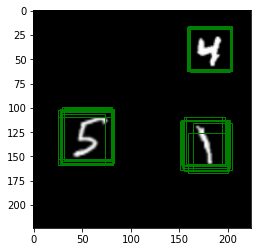

In [54]:
idx = np.random.randint(BATCH_SIZE)
from scipy.special import softmax

# top 10 predictions for each class
confidence, box_idx, delta = infer(y_pred[idx])
bbox_centre,bbox_hw = Bbox(confidence, box_idx, delta)

im = np.array(Image.fromarray(image[idx].numpy().astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

for i in range(outputChannels-4):
  # skipping backgrounds
    if i == NUM_CLASSES:
        continue
    color = 'r'
    # if a class is mentioned in the ground truth, color the boxes green
    if i in label[idx,:,0]:
        color = 'g'
        print(i)
    
    # skip all the classes which have low confidence values
    if (confidence[:,i] > 0.5).any() or i in label[idx,:,0]:
        for k in range(OBJperCLASS):
            print("{}: Confidence-{}\t\tCentre-{} Height,Width-{}".format(i,confidence[k,i],bbox_centre[k,i],bbox_hw[k,i]))
      
            # draw bounding box only if confidence scores are high
            if confidence[k,i] < 0.5:
                continue
            x = bbox_centre[k,i,0] - bbox_hw[k,i,0]/2
            y = bbox_centre[k,i,1] - bbox_hw[k,i,1]/2
            rect = patches.Rectangle((y,x),bbox_hw[k,i,1],bbox_hw[k,i,0],linewidth=1,edgecolor=color,facecolor='none')
            ax.add_patch(rect)

plt.show()